In [1]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

In [2]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=15000)

In [3]:
massive.head(1)

,id,title,audienceScore,tomatoMeter,reviewId,creationDate,criticName,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,delta
923460,stuber,Stuber,79.0,42.0,2604515,2019-07-12,Jim Judy,False,fresh,Screen It!,Nanjiani and Bautista milk the material -- som...,POSITIVE,-37.0


In [4]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])

In [5]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
dtype: int64

In [6]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title              7224
tomatoMeter       14886
criticName        11915
publicatioName    13494
reviewText            0
scoreSentiment    14984
delta             14856
dtype: int64

<AxesSubplot:xlabel='publicatioName', ylabel='Count'>

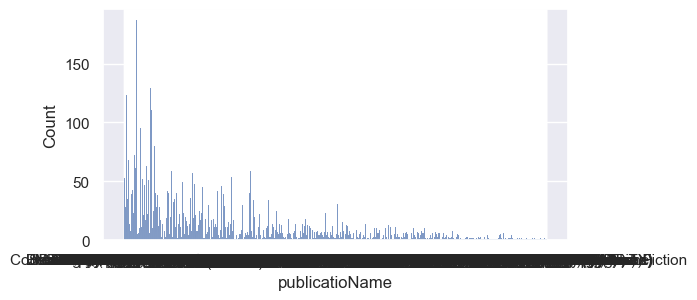

In [7]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=massive, x='publicatioName')

<AxesSubplot:xlabel='criticName', ylabel='Count'>

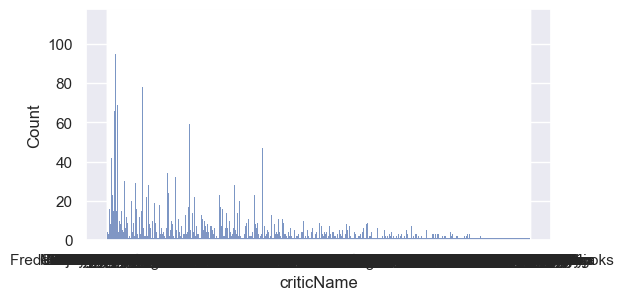

In [8]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=massive, x='criticName')

array([[<AxesSubplot:title={'center':'delta'}>]], dtype=object)

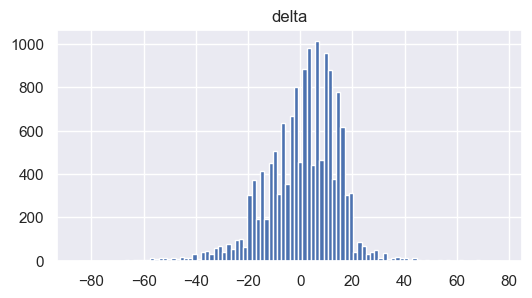

In [9]:
massive.hist(column='delta', bins=100)

In [10]:
# define a function to process text on the data
lemmatizer = WordNetLemmatizer()
import re
def process_text(text): 
    sw = set(stopwords.words('english')) 
    regex = re.compile("[^a-zA-Z ]") 
    re_clean = regex.sub('', text) 
    words = word_tokenize(re_clean) 
    lem = [lemmatizer.lemmatize(word) for word in words] 
    output = ' '.join([word.lower() for word in lem if word.lower() not in sw]) 
    return output

In [11]:
# use a lambda x function to apple process text on the whole column.
massive['reviewText'] = massive['reviewText'].apply(lambda x: process_text(x))

In [12]:
# tfidf vectorizer for sentiment model
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(massive['reviewText'])
y = massive['scoreSentiment']

In [13]:
# Split the data into training and testing sets for sentiment model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1] 
for learning_rate in learning_rates: 
    GBmodel = GradientBoostingClassifier(n_estimators=100, 
                                      learning_rate=learning_rate,
                                      max_features=2,
                                      max_depth=3,
                                      random_state=0)
    GBmodel.fit(X_train, y_train.ravel())
    print("Learning rate: ", learning_rate)
    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        GBmodel.score(
            X_train,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        GBmodel.score(
            X_test,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.705
Accuracy score (validation): 0.703

Learning rate:  0.1
Accuracy score (training): 0.705
Accuracy score (validation): 0.703

Learning rate:  0.25
Accuracy score (training): 0.711
Accuracy score (validation): 0.705

Learning rate:  0.5
Accuracy score (training): 0.742
Accuracy score (validation): 0.702

Learning rate:  0.75
Accuracy score (training): 0.745
Accuracy score (validation): 0.704

Learning rate:  1
Accuracy score (training): 0.746
Accuracy score (validation): 0.702



In [377]:
model.score(X_train, y_train)

0.8217276156336106

In [378]:
model.score(X_test, y_test)

0.7833239707888613

In [15]:
# Creating a dataframe made of the vectorized review text for the linear model
massive_features = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

C:\Users\Athen\anaconda3\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
massive_features.head(2)

,aaron,abandon,ability,able,absence,absolute,absolutely,absorbing,absurd,absurdity,...,youre,youth,youthful,youve,zack,zany,zemeckis,zero,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Need to rename column because title is also a column in massive_features
massive = massive.rename(columns={'title': 'title_'})

In [18]:
# Vectorizing original df to dense array for linear model
tfidf_dense = tfidf_vectorizer.fit_transform(massive['reviewText']).todense()

# Naming columns for each vectorized word and combining with original massive dataframe
new_cols = tfidf_vectorizer.get_feature_names()
combined = massive.join(pd.DataFrame(tfidf_dense, columns=new_cols))

C:\Users\Athen\anaconda3\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
# Dropping review text now that vectorized words are all columns
combined = combined.drop(columns=['reviewText'])

In [20]:
# Fill the nulls in all of the word columns with 0
combined = combined.fillna(0)

In [21]:
combined.isnull().sum().head(9)

title_            0
tomatoMeter       0
criticName        0
publicatioName    0
scoreSentiment    0
delta             0
aaron             0
abandon           0
ability           0
dtype: int64

In [22]:
# Renaming the least-appearing critics as Other to be encoded as the same critic later
counts = combined.criticName.value_counts()
threshold = combined.criticName.isin(counts.index[counts<16])
combined.loc[threshold, 'criticName'] = 'Other'
combined['criticName'].value_counts()

Other                            8940
Dennis Schwartz                   112
Frederic and Mary Ann Brussat      95
Roger Ebert                        78
Brian Orndorf                      71
                                 ... 
Erik Childress                     16
Jennie Kermode                     16
Marshall Fine                      16
Tim Grierson                       16
Scott Tobias                       16
Name: criticName, Length: 219, dtype: int64

In [23]:
# Repeat for publications
counts = combined.publicatioName.value_counts()
threshold = combined.publicatioName.isin(counts.index[counts<12])
combined.loc[threshold, 'publicatioName'] = 'Other'
combined['publicatioName'].value_counts()

Other                 4279
New York Times         187
Variety                187
Hollywood Reporter     142
Los Angeles Times      129
                      ... 
Newsweek                12
film-authority.com      12
Vanity Fair             12
JWR                     12
Cinema Sight            12
Name: publicatioName, Length: 324, dtype: int64

In [24]:
combined.head(1)

,title_,tomatoMeter,criticName,publicatioName,scoreSentiment,delta,aaron,abandon,ability,able,...,youre,youth,youthful,youve,zack,zany,zemeckis,zero,zombie,zone
923460,Stuber,42.0,Jim Judy,Screen It!,POSITIVE,-37.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# list of columns to dummy
categorical_cols = ['title_', 'criticName', 'publicatioName', 'scoreSentiment'] 
# get dummies on categorical columns
combined = pd.get_dummies(combined, columns = categorical_cols)

In [26]:
X = combined.drop(columns=['delta'])
y = combined['delta']

In [27]:
X.isnull().sum().sum()

0

In [28]:
y.isnull().sum()

0

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
X_train.isnull().sum().sum()

0

In [31]:
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [32]:
pca = PCA(n_components=500)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

In [34]:
# Choose a machine learning model (e.g., Logistic Regression) and train it
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1] 
for learning_rate in learning_rates: 
    GBmodel = GradientBoostingClassifier(n_estimators=100, 
                                      learning_rate=learning_rate,
                                      max_features=2,
                                      max_depth=3,
                                      random_state=0)
    GBmodel.fit(X_train_p, y_train.ravel())
    print("Learning rate: ", learning_rate)
    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        GBmodel.score(
            X_train_p,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        GBmodel.score(
            X_test_p,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.620
Accuracy score (validation): 0.103

Learning rate:  0.1
Accuracy score (training): 0.748
Accuracy score (validation): 0.124

Learning rate:  0.25
Accuracy score (training): 0.019
Accuracy score (validation): 0.007

Learning rate:  0.5
Accuracy score (training): 0.011
Accuracy score (validation): 0.003

Learning rate:  0.75
Accuracy score (training): 0.018
Accuracy score (validation): 0.015



KeyboardInterrupt: 

In [403]:
model.score(X_train_p, y_train)

0.03880947072601981

In [404]:
model.score(X_test_p, y_test)

0.018709247845990484

In [58]:
massive_full = pd.read_csv(filepath)

In [59]:
massive_full = massive_full.sort_values(by='delta')
print("Lowest values:")
massive_full_20 = massive_full.head(20)

Lowest values:


In [60]:
# Iterate over rows in massive_full
massive_full_cleaned = pd.DataFrame(columns=['reviewText'])
for index, row in massive_full_20.iterrows():
    if row['reviewText'] not in massive['reviewText'].values:
        # Drop the row from massive_full
        massive_full_cleaned = massive_full_cleaned.append(row, ignore_index=True)


# Print the resulting DataFrame
massive_full_cleaned

,reviewText,audienceScore,creationDate,criticName,delta,id,isTopCritic,publicatioName,reviewId,reviewState,scoreSentiment,title,tomatoMeter
0,A fun little horror movie making due on a clea...,96.0,2018-03-25,Rob Hunter,-87.0,against_the_night,0.0,Film School Rejects,2467190.0,fresh,POSITIVE,Against the Night,9.0
1,"There's real chemistry between the leads, and ...",99.0,2017-04-19,Tim Coleman,-86.0,finding_fatimah,0.0,Total Film,2389567.0,fresh,POSITIVE,Finding Fatimah,13.0
2,"Bad Kids Of Crestview Academy is bright, obnox...",96.0,2019-10-07,Joey Keogh,-86.0,bad_kids_of_crestview_academy_2017,0.0,Wicked Horror,2633279.0,fresh,POSITIVE,Bad Kids of Crestview Academy,10.0
3,The Tutor suffers from major logic flaws&#46; ...,92.0,2023-03-22,Julian Roman,-85.0,the_tutor_2023,0.0,MovieWeb,102791069.0,fresh,POSITIVE,The Tutor,7.0
4,Twisty enough to keep you interested till the ...,92.0,2023-03-26,Jackie K. Cooper,-85.0,the_tutor_2023,0.0,jackiekcooper.com,102792039.0,fresh,POSITIVE,The Tutor,7.0
5,It&#8217;s not the evocative queer suspense fi...,92.0,2023-03-28,Joe Lipsett,-85.0,the_tutor_2023,0.0,Bloody Disgusting,102792473.0,fresh,POSITIVE,The Tutor,7.0
6,This is a terrific little thriller that is inv...,92.0,2023-03-31,Tony Medley,-85.0,the_tutor_2023,0.0,The Larchmont Chronicle,102793721.0,fresh,POSITIVE,The Tutor,7.0
7,For those able to avoid the traps of over-crit...,92.0,2023-03-28,Keith Garlington,-85.0,the_tutor_2023,0.0,Arkansas Democrat-Gazette,102792424.0,fresh,POSITIVE,The Tutor,7.0
8,The action moves smoothly and quickly with goo...,92.0,2022-05-31,Alan Ng,-84.0,american_siege,0.0,Film Threat,102695069.0,fresh,POSITIVE,American Siege,8.0
9,Full of drama and romance -- and just a touch ...,95.0,2022-01-18,Tessa Smith,-84.0,redeeming_love,0.0,Mama's Geeky,2852911.0,fresh,POSITIVE,Redeeming Love,11.0


In [61]:
massive_full_desc = massive_full.sort_values(by='delta')
massive_full_desc_20 = massive_full_desc.tail(20)
massive_full_desc_20

,id,title,audienceScore,tomatoMeter,reviewId,creationDate,criticName,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,delta
131175,radio_dreams,Radio Dreams,20.0,95.0,2394150,2017-05-17,Wendy Ide,True,rotten,Screen International,Radio Dreams' aimless pacing and the character...,NEGATIVE,75.0
757583,unpregnant,Unpregnant,15.0,92.0,2722964,2020-09-11,Ty Burr,True,rotten,Boston Globe,Veronica and Bailey deserve better. So do Rich...,NEGATIVE,77.0
757584,unpregnant,Unpregnant,15.0,92.0,2721903,2020-09-08,Mark Jenkins,True,rotten,Slant Magazine,Its few nutty ideas demonstrate how little dis...,NEGATIVE,77.0
757582,unpregnant,Unpregnant,15.0,92.0,2723586,2020-09-12,Todd Jorgenson,False,rotten,Cinemalogue,Some charming performances can't offset the ov...,NEGATIVE,77.0
757581,unpregnant,Unpregnant,15.0,92.0,2723754,2020-09-12,Sean Burns,False,rotten,North Shore Movies,It plays like a very special episode of 'Sam &...,NEGATIVE,77.0
945629,stars_and_strife,Stars and Strife,12.0,90.0,2715389,2020-08-21,Wendy Shreve,False,rotten,Featuring Film,"A feel-good Michael Moore, [Director David] Sm...",NEGATIVE,78.0
725592,lowlife_love,Lowlife Love (Gesu no ai),0.0,80.0,2684427,2020-04-19,Emilie Black,False,rotten,Cinema Crazed,A lot of it feels as though the filmmaker is t...,NEGATIVE,80.0
946371,dementer,Dementer,0.0,83.0,2775299,2021-03-10,Keri O'Shea,False,rotten,Warped Perspective,Dementer sets out everything it's going to do ...,NEGATIVE,83.0
946372,dementer,Dementer,0.0,83.0,2774669,2021-03-07,Joel Fisher,False,rotten,Battle Royale With Cheese,There are some great visuals towards the end a...,NEGATIVE,83.0
946373,dementer,Dementer,0.0,83.0,2774399,2021-03-06,Rich Cross,False,rotten,Starburst,Dementer comes up short in trying to merge the...,NEGATIVE,83.0


In [63]:
massive_full_cleaned_2 = pd.DataFrame(columns=['reviewText'])
for index, row in massive_full_desc_20.iterrows():
    if row['reviewText'] not in massive['reviewText'].values:
        # Drop the row from massive_full
        massive_full_cleaned_2 = massive_full_cleaned_2.append(row, ignore_index=True)
        
massive_full_cleaned_2

,reviewText,audienceScore,creationDate,criticName,delta,id,isTopCritic,publicatioName,reviewId,reviewState,scoreSentiment,title,tomatoMeter
0,Radio Dreams' aimless pacing and the character...,20.0,2017-05-17,Wendy Ide,75.0,radio_dreams,1.0,Screen International,2394150.0,rotten,NEGATIVE,Radio Dreams,95.0
1,Veronica and Bailey deserve better. So do Rich...,15.0,2020-09-11,Ty Burr,77.0,unpregnant,1.0,Boston Globe,2722964.0,rotten,NEGATIVE,Unpregnant,92.0
2,Its few nutty ideas demonstrate how little dis...,15.0,2020-09-08,Mark Jenkins,77.0,unpregnant,1.0,Slant Magazine,2721903.0,rotten,NEGATIVE,Unpregnant,92.0
3,Some charming performances can't offset the ov...,15.0,2020-09-12,Todd Jorgenson,77.0,unpregnant,0.0,Cinemalogue,2723586.0,rotten,NEGATIVE,Unpregnant,92.0
4,It plays like a very special episode of 'Sam &...,15.0,2020-09-12,Sean Burns,77.0,unpregnant,0.0,North Shore Movies,2723754.0,rotten,NEGATIVE,Unpregnant,92.0
5,"A feel-good Michael Moore, [Director David] Sm...",12.0,2020-08-21,Wendy Shreve,78.0,stars_and_strife,0.0,Featuring Film,2715389.0,rotten,NEGATIVE,Stars and Strife,90.0
6,A lot of it feels as though the filmmaker is t...,0.0,2020-04-19,Emilie Black,80.0,lowlife_love,0.0,Cinema Crazed,2684427.0,rotten,NEGATIVE,Lowlife Love (Gesu no ai),80.0
7,Dementer sets out everything it's going to do ...,0.0,2021-03-10,Keri O'Shea,83.0,dementer,0.0,Warped Perspective,2775299.0,rotten,NEGATIVE,Dementer,83.0
8,There are some great visuals towards the end a...,0.0,2021-03-07,Joel Fisher,83.0,dementer,0.0,Battle Royale With Cheese,2774669.0,rotten,NEGATIVE,Dementer,83.0
9,Dementer comes up short in trying to merge the...,0.0,2021-03-06,Rich Cross,83.0,dementer,0.0,Starburst,2774399.0,rotten,NEGATIVE,Dementer,83.0
